In [223]:
import io
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge

In [224]:
historical_weather = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\historical_weather.csv")
test_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [225]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [226]:
historical_weather.shape

(182338, 9)

In [227]:
test_data.shape

(700, 3)

In [228]:
historical_weather.describe()

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
count,181114.000000,176452.000000,174845.000000,112594.000000,12238.000000,146944.000000,159866.000000
mean,19.137516,14.627775,23.887261,3.679964,342.481696,175.650289,11.281875
std,9.902722,10.004998,10.446670,11.294167,1020.265388,105.435150,6.132884
min,-34.700000,-43.800000,-28.500000,0.000000,0.000000,0.000000,0.000000
25%,12.400000,7.500000,17.100000,0.000000,0.000000,83.000000,7.200000
50%,21.400000,16.200000,27.000000,0.000000,10.000000,178.000000,9.900000
75%,27.100000,23.300000,31.500000,2.300000,140.000000,266.000000,14.000000
max,41.900000,38.900000,49.100000,496.100000,7140.000000,360.000000,80.000000


In [229]:
historical_weather.dtypes[historical_weather.dtypes != 'object']

avg_temp_c            float64
min_temp_c            float64
max_temp_c            float64
precipitation_mm      float64
snow_depth_mm         float64
avg_wind_dir_deg      float64
avg_wind_speed_kmh    float64
dtype: object

In [230]:
historical_weather.dtypes[historical_weather.dtypes == 'object']

city_id    object
date       object
dtype: object

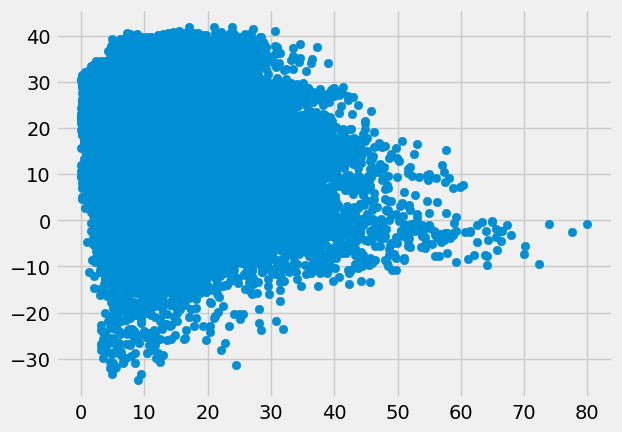

In [231]:
plt.scatter(x='avg_wind_speed_kmh', y='avg_temp_c', data=historical_weather)

In [232]:
#Missing value handling

In [233]:
pd.DataFrame(historical_weather.isnull().sum().sort_values(ascending=False)).head(20)

,0
snow_depth_mm,170100
precipitation_mm,69744
avg_wind_dir_deg,35394
avg_wind_speed_kmh,22472
max_temp_c,7493
min_temp_c,5886
avg_temp_c,1224
city_id,0
date,0


In [234]:
##Drop snow_depth_mm column

In [235]:
historical_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [236]:
# num_cols = historical_weather.select_dtypes(include=['int64', 'float64']).columns

In [237]:
# num_pipeline = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

In [238]:
# col_trans = ColumnTransformer(transformers=[
#     ('num_p', num_pipeline, num_cols)
#     ],
#     remainder='passthrough', 
#     n_jobs=-1)

In [239]:
#  pipeline = Pipeline(steps=[
#     ('preprocessing', col_trans)
# ])

In [240]:
# preprocessed = pipeline.fit_transform(historical_weather)

In [241]:
# historical_weather = pd.DataFrame(historical_weather)

In [242]:
#Feature Engineering

In [243]:
print(type(historical_weather))

<class 'pandas.core.frame.DataFrame'>


In [244]:
# historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [245]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [246]:
historical_weather['city_id'] = historical_weather['city_id'].str.extract('(\d+)').astype(int)
test_data['city_id'] = test_data['city_id'].str.extract('(\d+)').astype(int)

historical_df = historical_weather.copy()

In [247]:
historical_weather['city_id'].unique()

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  20,  22,  23,  24,  25,  27,  28,  29,  30,
        31,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,
        46,  47,  48,  49,  51,  53,  54,  55,  56,  57,  58,  59,  61,
        62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,
        77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112])

In [248]:
plt.figure(figsize=(15, 5))
for city in historical_weather['city_id'].unique():
    city_data = historical_weather[historical_weather['city_id'] == city]
    plt.plot(city_data['date'], city_data['avg_temp_c'], '.', label=f'City {city}')

plt.title('Average Temperature in Celsius Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

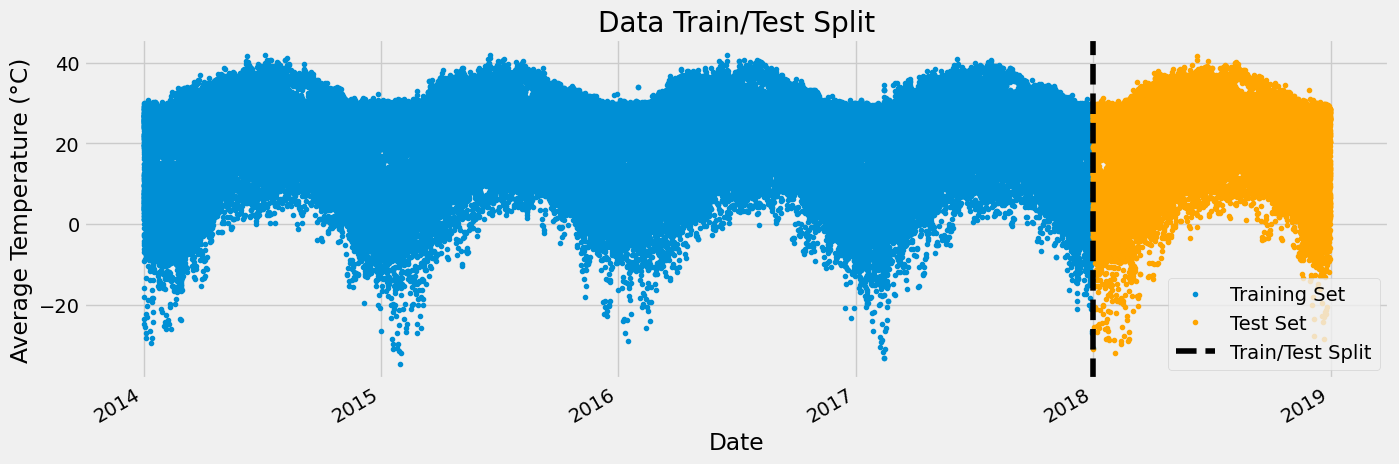

In [ ]:
train = historical_weather.loc[historical_weather['date'] < '01-01-2018']
test = historical_weather.loc[historical_weather['date'] >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='date', y='avg_temp_c', ax=ax, label='Training Set', style='.')
test.plot(x='date', y='avg_temp_c', ax=ax, label='Test Set', style='.', color='orange')
ax.axvline(pd.to_datetime('01-01-2018'), color='black', ls='--')
ax.set_title('Data Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature (°C)')
ax.legend(['Training Set', 'Test Set', 'Train/Test Split'])

plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    return df

historical_weather = create_features(historical_weather)

In [ ]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2,2,1,1,2014,1,1,1
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0,3,1,1,2014,2,2,1
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8,4,1,1,2014,3,3,1
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3,5,1,1,2014,4,4,1
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0,6,1,1,2014,5,5,1


In [ ]:
historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [ ]:
historical_weather.head()

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1


In [ ]:
#missing values handling

In [ ]:
imputer = SimpleImputer(strategy='mean')

In [ ]:
historical_weather['avg_temp_c'] = imputer.fit_transform(historical_weather[['avg_temp_c']])


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# historical_weather = historical_weather.sort_index()

In [ ]:
historical_weather['year'].unique()

array([2014, 2015, 2016, 2017, 2018])

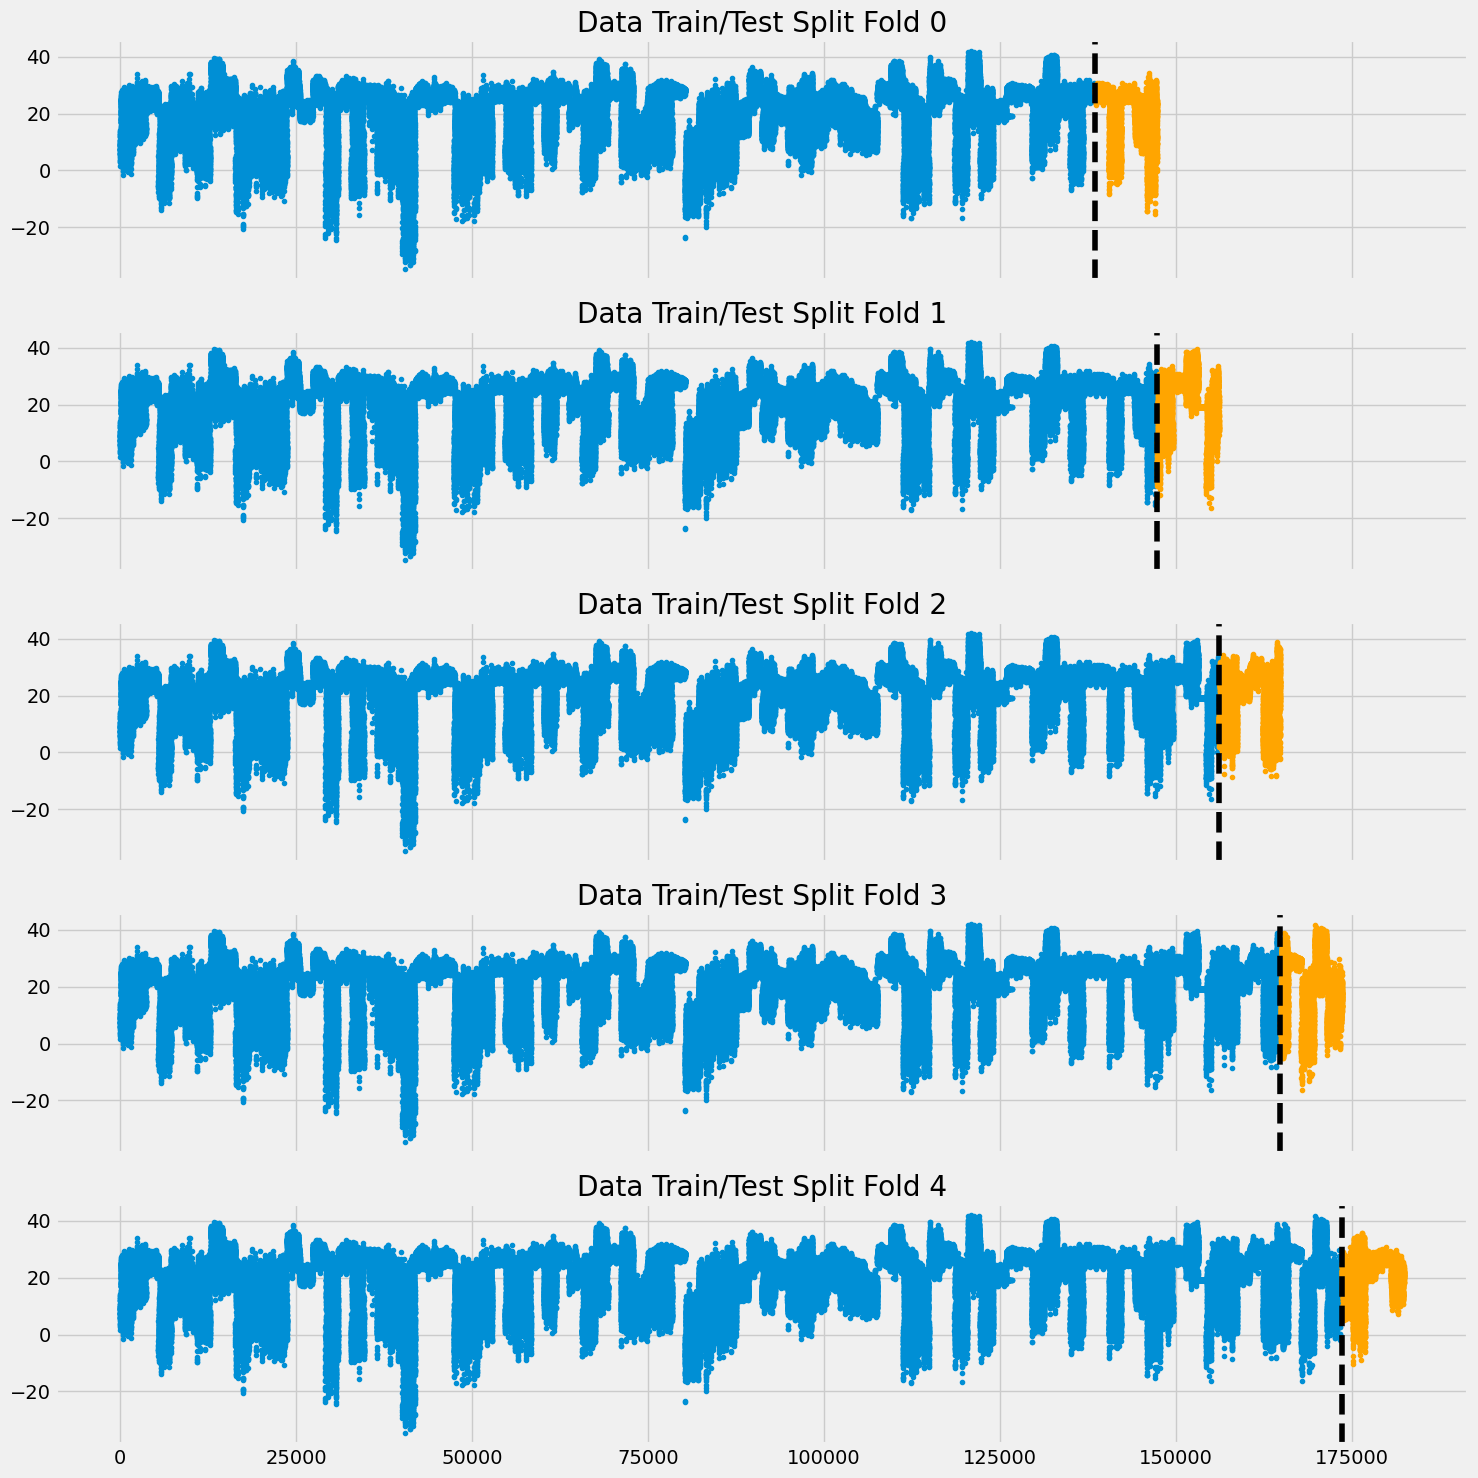

In [ ]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]
    train['avg_temp_c'].plot(x='date',ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',style='.')
    test['avg_temp_c'].plot(x='date',ax=axs[fold],
                         label='Test Set',style='.',color='orange')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.tight_layout()
plt.show()

In [ ]:
# historical_weather = historical_weather.drop(columns=['date'])

In [ ]:
historical_weather

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1
...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,3,4,12,2018,361,27,52
182334,112,2018-12-28,21.9,4,4,12,2018,362,28,52
182335,112,2018-12-29,22.4,5,4,12,2018,363,29,52
182336,112,2018-12-30,21.6,6,4,12,2018,364,30,52


In [ ]:
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('city_id')[col].shift(lag)
    return df

In [ ]:
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7]  # 1-day, 2-day, 3-day, 7-day, 14-day, and 30-day lags
historical_weather = create_lag_features(historical_weather, lags, lag_features)

In [ ]:
historical_weather.head()

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN


In [ ]:
# historical_weather = historical_weather.fillna(0.0)

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
historical_weather = historical_weather.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['city_id','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
    TARGET = 'avg_temp_c'

    X_train = train[FEATURES]
    y_train = np.log(train[TARGET])

    X_test = test[FEATURES]
    y_test = np.log(test[TARGET])


    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=50000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Expected 2D array, got 1D array instead:
array=[1.88706965 2.2300144  2.02814825 ... 3.33932198 3.31054301 3.28840189].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.7791
Fold scores:[1.7999702181832329, 1.6731746886083187, 1.770538226062497, 1.8487643279096373, 1.8028201164876925]


In [ ]:
# Retrain on all data
historical_weather = create_features(historical_weather)

FEATURES = ['city_id','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
TARGET = 'avg_temp_c'

X_all = historical_weather[FEATURES]
y_all = np.log(historical_weather[TARGET])

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=50000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:20.88149


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.90895
[200]	validation_0-rmse:3.41622
[300]	validation_0-rmse:2.15175
[400]	validation_0-rmse:1.90349
[500]	validation_0-rmse:1.86018
[600]	validation_0-rmse:1.85012
[700]	validation_0-rmse:1.84430
[800]	validation_0-rmse:1.84027
[900]	validation_0-rmse:1.83644
[1000]	validation_0-rmse:1.83310
[1100]	validation_0-rmse:1.83014
[1200]	validation_0-rmse:1.82780
[1300]	validation_0-rmse:1.82569
[1400]	validation_0-rmse:1.82364
[1500]	validation_0-rmse:1.82169
[1600]	validation_0-rmse:1.81967
[1700]	validation_0-rmse:1.81786
[1800]	validation_0-rmse:1.81623
[1900]	validation_0-rmse:1.81471
[2000]	validation_0-rmse:1.81314
[2100]	validation_0-rmse:1.81168
[2200]	validation_0-rmse:1.81022
[2300]	validation_0-rmse:1.80885
[2400]	validation_0-rmse:1.80762
[2500]	validation_0-rmse:1.80630
[2600]	validation_0-rmse:1.80486
[2700]	validation_0-rmse:1.80360
[2800]	validation_0-rmse:1.80242
[2900]	validation_0-rmse:1.80129
[3000]	validation_0-rmse:1.80018
[3100]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
test_data['isFuture'] = True
historical_df['isFuture'] = False
df_and_future = pd.concat([historical_df, test_data])
df_and_future = create_features(df_and_future)
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7] 
df_and_future = create_lag_features(df_and_future,lags,lag_features)


In [ ]:
historical_weather

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,3,4,12,2018,361,27,52,22.3,21.9,20.6,19.3,18.5,19.2,21.0
182334,112,2018-12-28,21.9,4,4,12,2018,362,28,52,22.0,22.3,21.9,20.6,19.3,18.5,19.2
182335,112,2018-12-29,22.4,5,4,12,2018,363,29,52,21.9,22.0,22.3,21.9,20.6,19.3,18.5
182336,112,2018-12-30,21.6,6,4,12,2018,364,30,52,22.4,21.9,22.0,22.3,21.9,20.6,19.3


In [ ]:
df_and_future

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,isFuture,submission_ID,...,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2,False,NaN,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0,False,NaN,...,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8,False,NaN,...,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3,False,NaN,...,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0,False,NaN,...,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,True,696.0,...,3,3,1,NaN,NaN,20.2,21.6,22.4,21.9,22.0
696,112,2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,True,697.0,...,4,4,1,NaN,NaN,NaN,20.2,21.6,22.4,21.9
697,112,2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,True,698.0,...,5,5,1,NaN,NaN,NaN,NaN,20.2,21.6,22.4
698,112,2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN,True,699.0,...,6,6,1,NaN,NaN,NaN,NaN,NaN,20.2,21.6


In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
features = ['submission_ID','city_id','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
future_w_features  = future_w_features[features].sort_values(by='submission_ID', ascending=True).drop(columns=['submission_ID'])

future_w_features

,city_id,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,1,1,1,2019,1,1,1,11.8,10.7,8.9,10.1,9.7,9.4,9.0
1,1,2,1,1,2019,2,2,1,NaN,11.8,10.7,8.9,10.1,9.7,9.4
2,1,3,1,1,2019,3,3,1,NaN,NaN,11.8,10.7,8.9,10.1,9.7
3,1,4,1,1,2019,4,4,1,NaN,NaN,NaN,11.8,10.7,8.9,10.1
4,1,5,1,1,2019,5,5,1,NaN,NaN,NaN,NaN,11.8,10.7,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,3,1,1,2019,3,3,1,NaN,NaN,20.2,21.6,22.4,21.9,22.0
696,112,4,1,1,2019,4,4,1,NaN,NaN,NaN,20.2,21.6,22.4,21.9
697,112,5,1,1,2019,5,5,1,NaN,NaN,NaN,NaN,20.2,21.6,22.4
698,112,6,1,1,2019,6,6,1,NaN,NaN,NaN,NaN,NaN,20.2,21.6


In [ ]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
avg_temp_c_lag_1,600
avg_temp_c_lag_2,500
avg_temp_c_lag_3,400
avg_temp_c_lag_4,300
avg_temp_c_lag_5,200
avg_temp_c_lag_6,100
city_id,0
dayofweek,0
quarter,0
month,0


In [ ]:
# future_w_features = future_w_features.fillna(0.0)

In [ ]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
avg_temp_c_lag_1,600
avg_temp_c_lag_2,500
avg_temp_c_lag_3,400
avg_temp_c_lag_4,300
avg_temp_c_lag_5,200
avg_temp_c_lag_6,100
city_id,0
dayofweek,0
quarter,0
month,0


In [ ]:
# future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']] = imputer.fit_transform(future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']])

In [ ]:
# Y_pred_1 = reg.predict(future_w_features)
# Y_pred_2 = reg.predict(future_w_features)


In [ ]:
# submission_1 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_1
# })
# submission_2 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_2
# })


In [ ]:
# submission_1.to_csv("submission_1.csv", index=False)
# submission_2.to_csv("submission_2.csv", index=False)


In [ ]:
# X = historical_weather.drop(['avg_temp_c','date'],axis = 1)
# y = historical_weather['avg_temp_c']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle= False)

In [ ]:
# pd.DataFrame(X_train.isnull().sum().sort_values(ascending=False)).head(20)

In [ ]:
# XGB = XGBRegressor(booster='gbtree',objective='reg:squarederror')

In [ ]:
# param_grid_XGB = {
#     'base_score':[0.5],
#     'learning_rate': [0.05,0.01, 0.1, 0.2],
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1,2,3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }

In [ ]:
# xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# xgb_cv.fit(X_train, y_train)

In [ ]:
# xgb_cv.best_estimator_

In [ ]:
# np.sqrt(-1 * xgb_cv.best_score_)

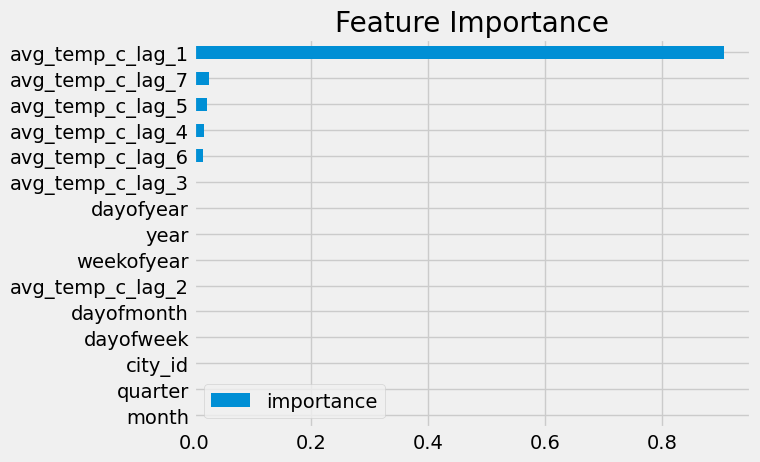

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# feature_importances = reg.best_estimator_.feature_importances_
# feature_names = reg.best_estimator_.feature_names_in_
# fi = pd.DataFrame(data=feature_importances,
#                   index=feature_names,
#                   columns=['importance'])
# fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
# plt.show()

In [ ]:
# ll=[]
# ll.append(np.abs(y_test - xgb_cv.predict(X_test)))
# ll


In [ ]:
# lr = LinearRegression()

In [ ]:
# lr.fit(X_train, y_train)

In [ ]:
# y_pred_lr = lr.predict(X_test)

In [ ]:
# np.sqrt(mean_squared_error(y_test, y_pred_lr))